# 02 IRL: 01 Bayes

---
## 0. Setup

In [1]:
import numpy as np
np.set_printoptions(precision=2)  # 数値桁数を指定．

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

from datetime import datetime

---
## 1. Environment

In [2]:
class Environment(object):
    def __init__(self, 
                 liability_CF=np.array([0, 0, 0, 0, -5]), 
                 initial_asset=10, 
                 max_asset=10, 
                 gamma=0.90):
        self.t = 0
        self.liability_CF = liability_CF
        self.initial_asset = initial_asset
        self.max_asset = max_asset
        self.gamma = gamma
        self.term = len(liability_CF)  # 行動選択回数はこれだが，状態の時点数は終端があるのでこれ+1である．
        
        
    def step(self, action, verbose=False):
        pass
        
        
    def reset(self,):
        pass

    
    def PolicyIteration(self, R):
        # この環境は必ず終端するので，DPで一気に求めてしまう．
        # RとVとで若干意味合いが混乱するので注意．
        # 即時報酬は状態のみに応じて決まるようにしている．しかし，これは状態価値関数がそのように定義されていることを意味しない．
        # この即時報酬の行動を反映しているのはあくまで即時報酬規則RであってVではない．つまり，Vにはその状態に到達する際に獲得される即時報酬は含まれない．
        # その故に，終端状態のRはゼロとは限らないが，終端状態のVはゼロである．
        V = np.zeros(shape=(self.term+1, 1+self.max_asset))
        Q = np.zeros(shape=(self.term+1, 1+self.max_asset, 1+self.max_asset))
        
        for t in range(self.term-1, 0-1, -1):
            V[t] = np.array([np.max(R[t, s, :s+1] + self.gamma * V[t+1][:s+1]) for s in range(self.max_asset+1)])
            Q[t] = R[t] + self.gamma * V[t+1].reshape(1, -1) * np.tri(len(V[t+1]))  # s, a
            # V[t+1]はs成分しか持っていない．しかし，Q[t, s, a] = R[t, s, a] + gamma * V[t+1, a]である．
            # このため，reshapeでV[t+1, a]をV[t+1, 0, a]にしている．
            # 但し，これだけだとsから到達不能なaも含んでしまう．
        Q[:, np.array(1-np.tri(len(Q[-1])), dtype=bool)] = np.nan
            
        return V, Q

    
    def calc_greedy_policy(self, Q):
        return np.array([np.nanargmax(Q[t, :, :], axis=-1) for t in range(self.term)])  # t, s : nanargmaxでないと，nanを最大インデックスと見なすので注意．
        
    
    def calc_Q(self, R, Policy):
        Q = np.zeros(shape=(self.term+1, 1+self.max_asset, 1+self.max_asset))
        Q[self.term-1] = R[self.term-1]
        for t in range(self.term-2, 0-1, -1):
            Q[t] = R[t] + self.gamma * Q[t+1][np.arange(1+self.max_asset), Policy[t+1, :]].reshape(1, -1)
        Q[:, np.array(1-np.tri(len(Q[-1])), dtype=bool)] = np.nan
        
        return Q
    
    
    def calc_Pr(self, Q, trajectory):
        return np.nansum([Q[t, trajectory[t][0], trajectory[t][1]] for t in range(len(trajectory))])
    
    
    def calc_Prs(self, Q, trajectories):
        # trajectories should have th form as set of (t, s, a).
        return np.nansum([Q[trajectory[0], trajectory[1], trajectory[2]] for trajectory in trajectories])
    
    
    def calc_all_greedy_trajectories(self, greedy_policy):
        trajectories = []
        for t in range(self.term):
            for s in range(1 + self.max_asset):
                trajectories.append([t, s, greedy_policy[t, s]])
        
        return trajectories
    
    

In [3]:
env = Environment()

In [4]:
# create R for SP annuity of term = 10
R = np.zeros(shape=(env.term, 1+env.max_asset, 1+env.max_asset))
for t in range(env.term):
    for s in range(1+env.max_asset):
        for a in range(s+1):
            R[t, s, a] = max(0, s - a)
R[-1, :, :] += np.arange(1+env.max_asset).reshape(1, -1)  # remained asset at EoY
R[-1, :, :] += env.liability_CF[-1]  # final payout
R[-1, :, :-env.liability_CF[-1]] += -30  # bunkrupt penalty
R[:, np.array(1-np.tri(len(R[-1])), dtype=bool)] = np.nan  # cut out impossible action

In [5]:
def show_VQP(env, R, annot=False):
    V, Q = env.PolicyIteration(R)
    policy = env.calc_greedy_policy(Q)

    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1 = sns.heatmap(V, annot=annot, cmap='jet', square=True)
    ax1.set_title('V')
    ax1.set_xlabel('asset')
    ax1.set_ylabel('t')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy, annot=True, cmap='jet', square=True)
    ax2.set_title('Greedy Policy')
    ax2.set_xlabel('asset')
    ax2.set_ylabel('t')
    plt.show()


    if True:
        for t in range(env.term):
            fig = plt.figure(figsize=(16, 6))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1 = sns.heatmap(R[t], annot=annot, cmap='jet', square=True)
            ax1.set_title('R : t={}'.format(t))
            ax1.set_xlabel('reserve')
            ax1.set_ylabel('asset')

            ax2 = fig.add_subplot(1, 2, 2)
            ax2 = sns.heatmap(Q[t], annot=annot, cmap='jet', square=True)
            ax2.set_title('Q : t={}'.format(t))
            ax2.set_xlabel('reserve')
            ax2.set_ylabel('asset')
            plt.show()

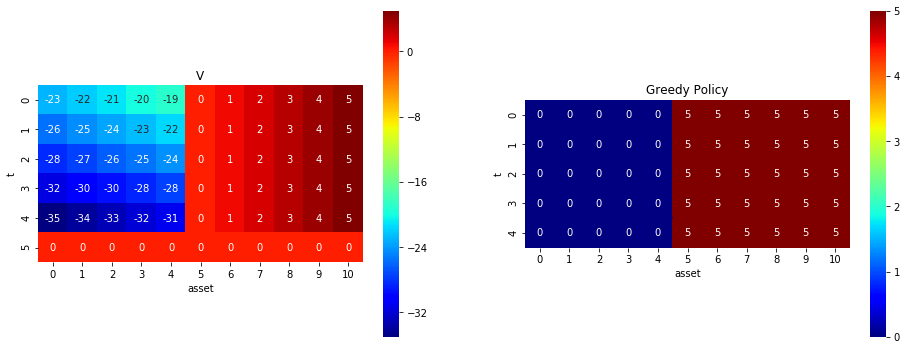

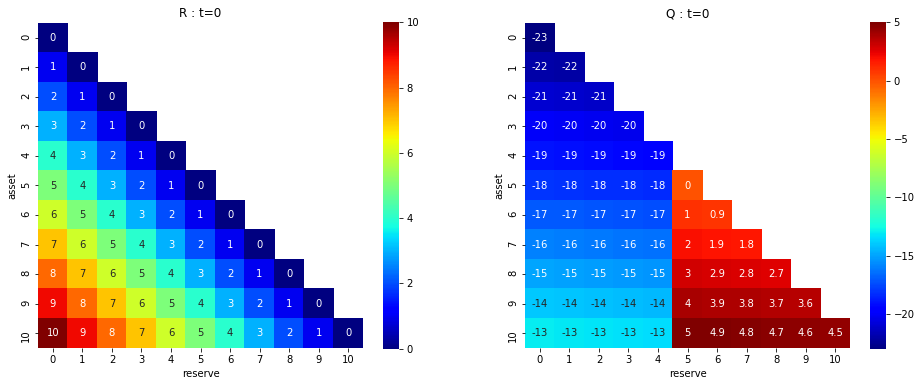

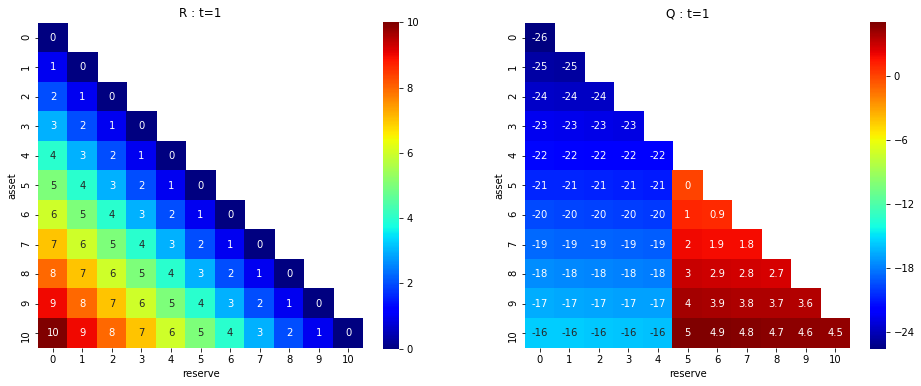

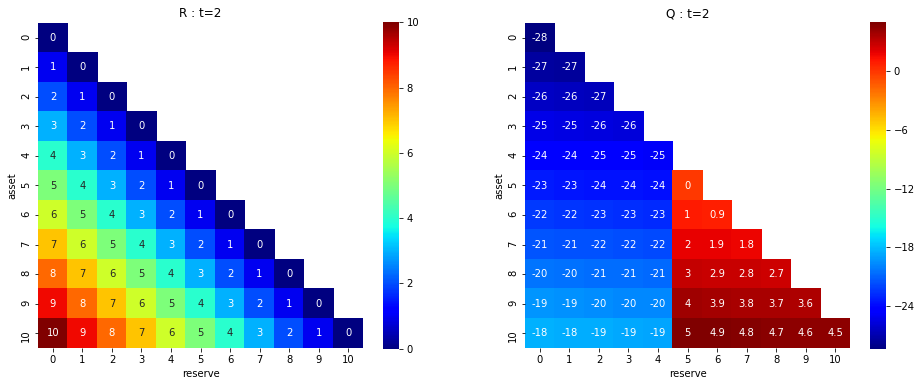

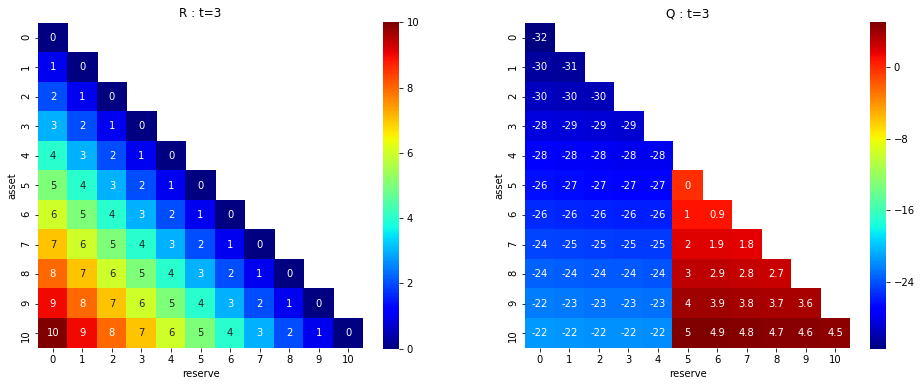

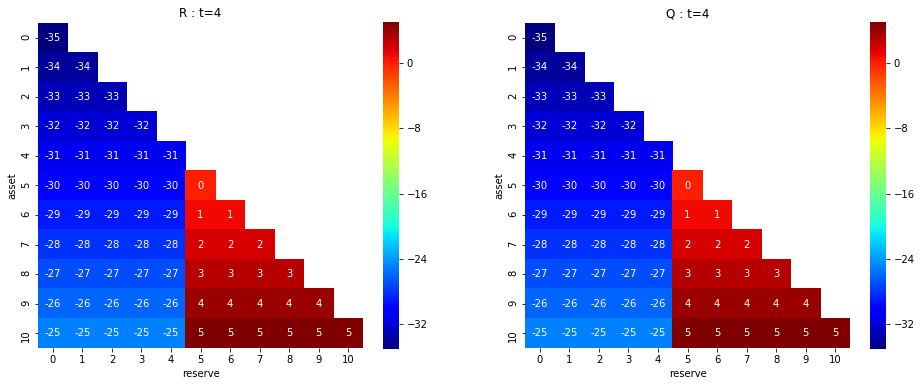

In [6]:
show_VQP(env, R, True)

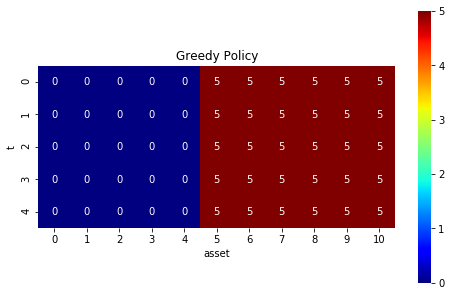

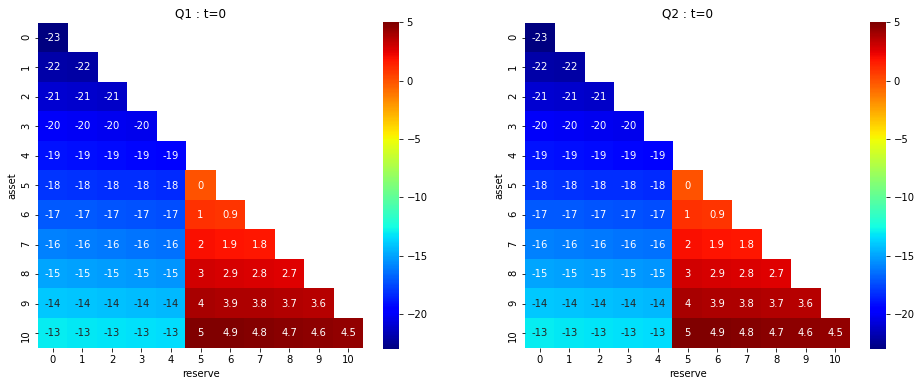

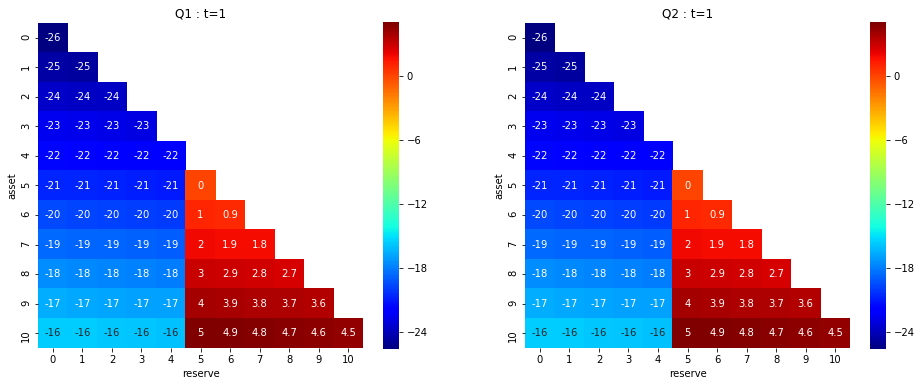

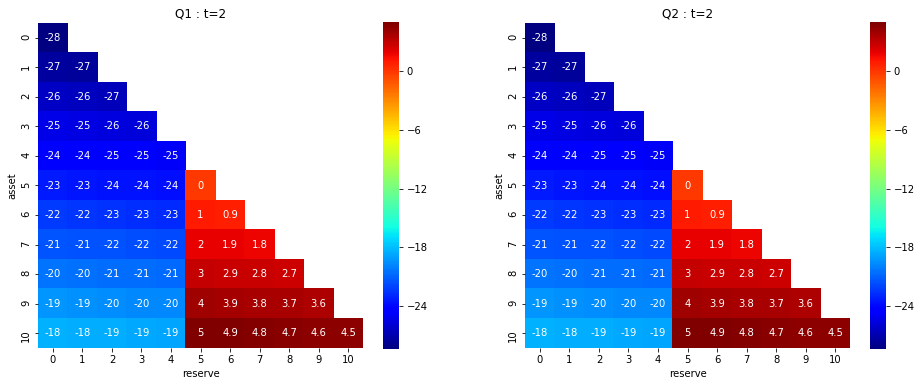

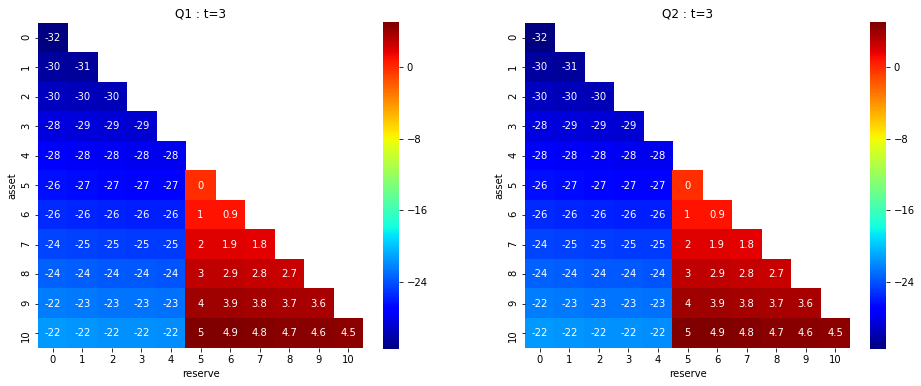

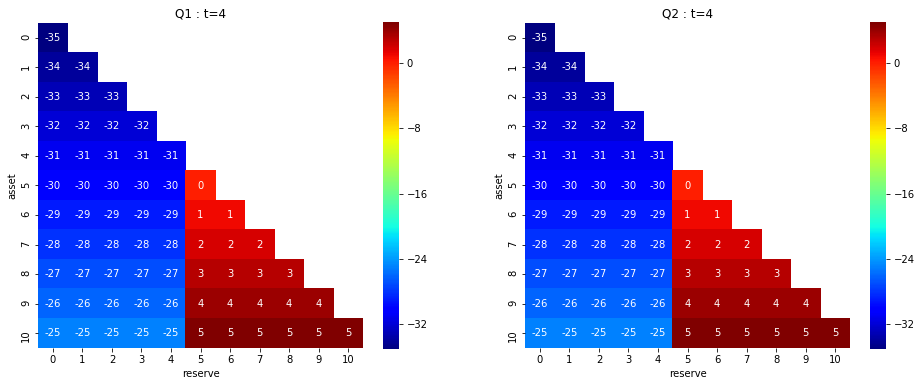

In [7]:
# check
V, Q1 = env.PolicyIteration(R)
policy = env.calc_greedy_policy(Q1)

plt.figure(figsize=(8, 5))
sns.heatmap(policy, annot=True, square=True, cmap='jet')
plt.title('Greedy Policy')
plt.xlabel('asset')
plt.ylabel('t')
plt.show()


Q2 = env.calc_Q(R, policy)
if True:
    for t in range(env.term):
        fig = plt.figure(figsize=(16, 6))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1 = sns.heatmap(Q1[t], annot=True, cmap='jet', square=True)
        ax1.set_title('Q1 : t={}'.format(t))
        ax1.set_xlabel('reserve')
        ax1.set_ylabel('asset')
    
        ax2 = fig.add_subplot(1, 2, 2)
        ax2 = sns.heatmap(Q2[t], annot=True, cmap='jet', square=True)
        ax2.set_title('Q2 : t={}'.format(t))
        ax2.set_xlabel('reserve')
        ax2.set_ylabel('asset')
        plt.show()

---
## 2. Bayesian IRL on 1 trajectry

In [8]:
def BIRL(env, trajectories, n_iterations=10000, n_intervals=1000, delta=1, epsilon=0.01, alpha=0.1):
    Rs = []
    R = (np.random.uniform(size=(env.term, 1+env.max_asset, 1+env.max_asset))-0.5) * delta
    #R /= np.sqrt(np.sum(R**2) + 1e-6)
    accepted = 0
    
    for _ in range(n_iterations):
        V, Q = env.PolicyIteration(R)
        policy_current = env.calc_greedy_policy(Q)

        R_sample = R + (np.random.uniform(size=R.shape)-0.5) * delta * epsilon  # (a)
        #R_sample /= np.sqrt(np.sum(R_sample**2) + 1e-6)

        Q_next = env.calc_Q(R_sample, policy_current)  # (b)
        Q_star = env.PolicyIteration(R_sample)[1]

        if np.any(Q_next<Q_star):  # 論文の式と若干変えている．
            policy_star = env.calc_greedy_policy(Q_star)  # i
            check = min(np.exp(alpha * (env.calc_Prs(Q_star, trajectories) - env.calc_Prs(Q, trajectories)) / len(trajectories)), 1)
            #print('case 1 : ', check)
            if np.random.uniform() < check:
                accepted += 1
                R = R_sample
                policy = policy_star
        else:
            check = min(np.exp(alpha * (env.calc_Prs(Q_next, trajectories) - env.calc_Prs(Q, trajectories)) / len(trajectories)), 1)
            #print('case 2 : ', check, np.exp(alpha * (env.calc_Prs(Q_next, trajectories) - env.calc_Prs(Q, trajectories))))
            if np.random.uniform() < check:
                accepted += 1
                R = R_sample

        if _ % n_intervals == 0:
            print('{} th iteration...'.format(_))
            R /= np.sqrt(np.sum(R**2) + 1e-6)  # reset R scale
            fig = plt.figure(figsize=(14, 5))
            for t in range(env.term):
                ax1 = fig.add_subplot(2, 5, t+1)
                ax1 = sns.heatmap(R[t], annot=False, cmap='jet', square=True)
                ax1.set_title('R : t={}'.format(t))
                ax1.set_xlabel('reserve')
                ax1.set_ylabel('asset')
            plt.tight_layout()
            plt.show()
            Rs.append(np.copy(R))
    
    print('iterations = {}, accepted = {}, ratio = {}'.format(n_iterations, accepted, accepted / n_iterations))
    return Rs

In [9]:
trajectory = np.zeros(shape=(env.term, 3), dtype=int)
trajectory[0] = 0, env.initial_asset, 5
trajectory[1:, 1:] = 5
trajectory[:, 0] = np.arange(len(trajectory))
trajectory

array([[ 0, 10,  5],
       [ 1,  5,  5],
       [ 2,  5,  5],
       [ 3,  5,  5],
       [ 4,  5,  5]])

start :  2019-09-18 10:00:21.345142
0 th iteration...


/Users/RyoMiyazaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


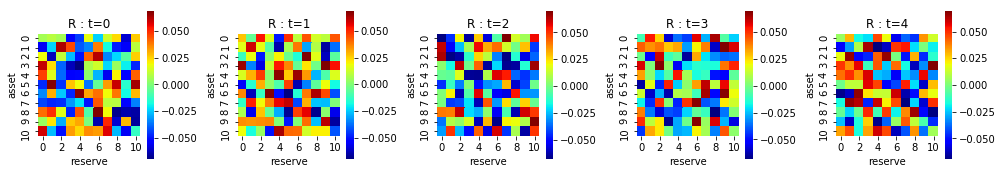

30000 th iteration...


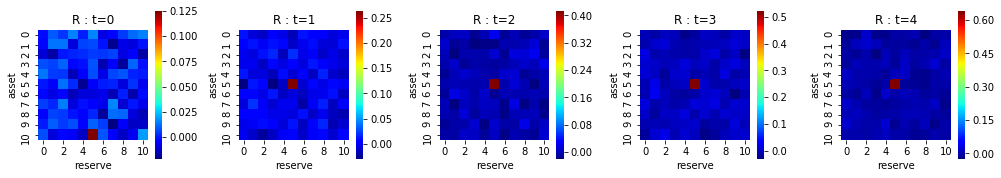

60000 th iteration...


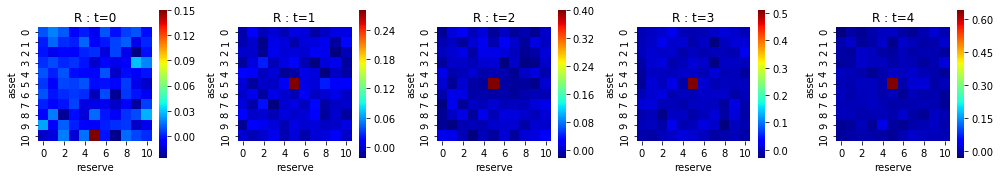

90000 th iteration...


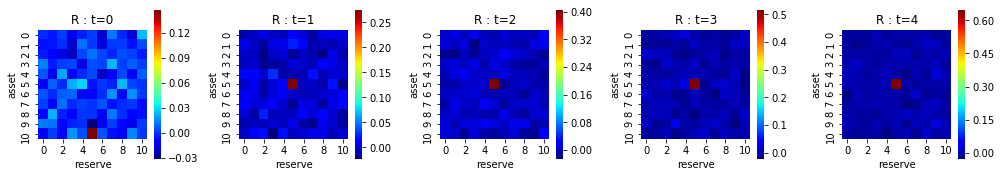

120000 th iteration...


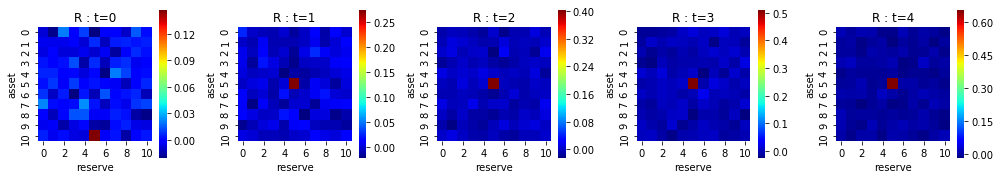

150000 th iteration...


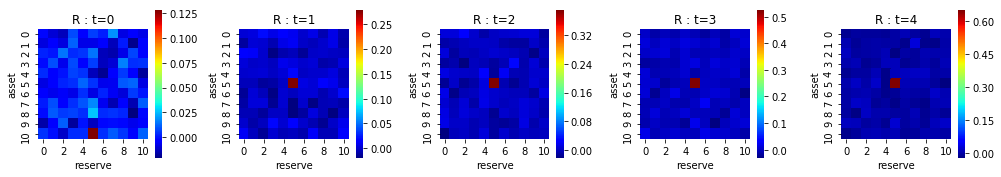

180000 th iteration...


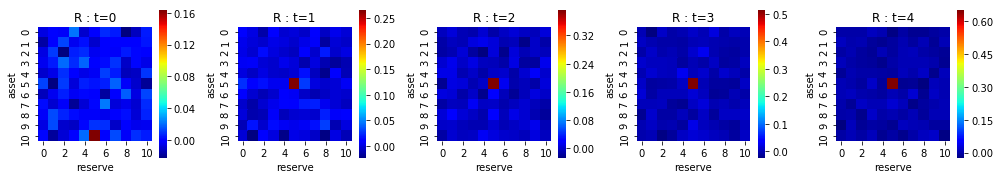

210000 th iteration...


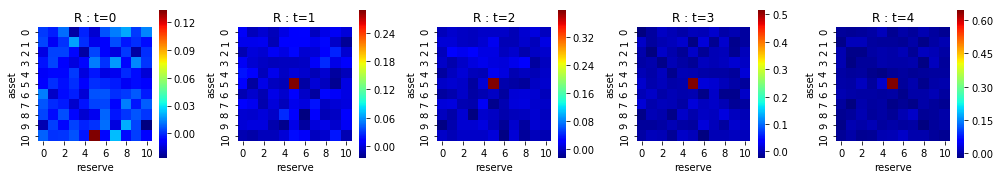

240000 th iteration...


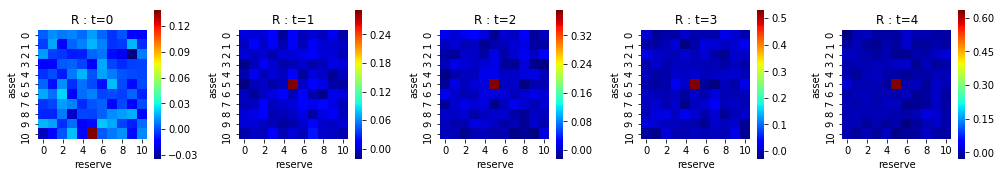

270000 th iteration...


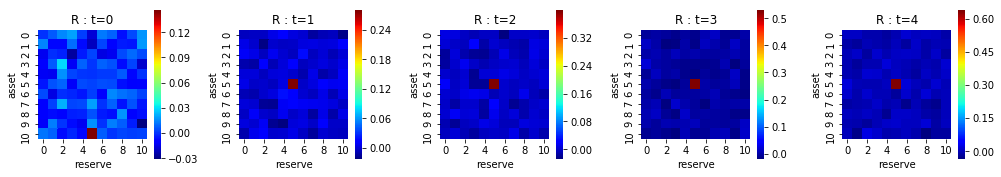

iterations = 300000, accepted = 152496, ratio = 0.50832
end :  2019-09-18 10:11:28.981639


In [11]:
print('start : ', datetime.now())
Rs = BIRL(env, trajectory, 300000, 30000, delta=1, epsilon=0.1, alpha=1000.0)
print('end : ', datetime.now())

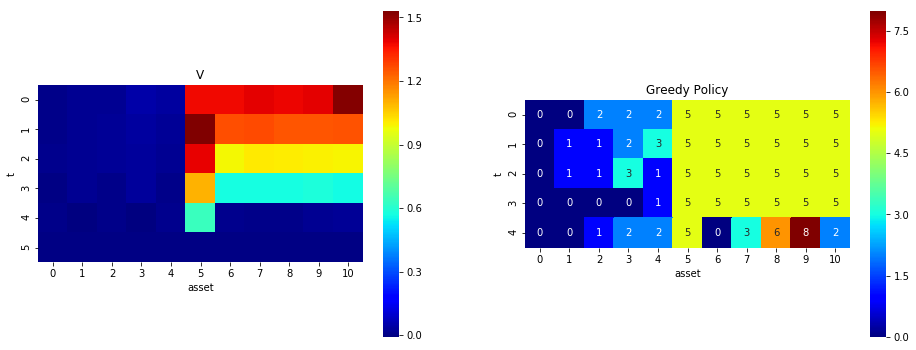

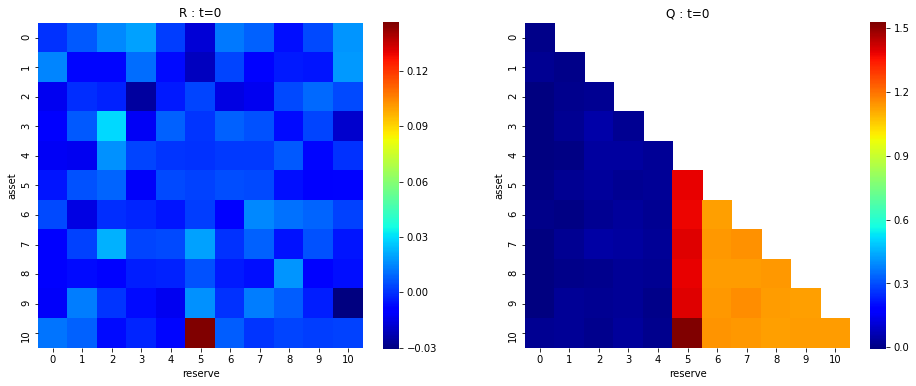

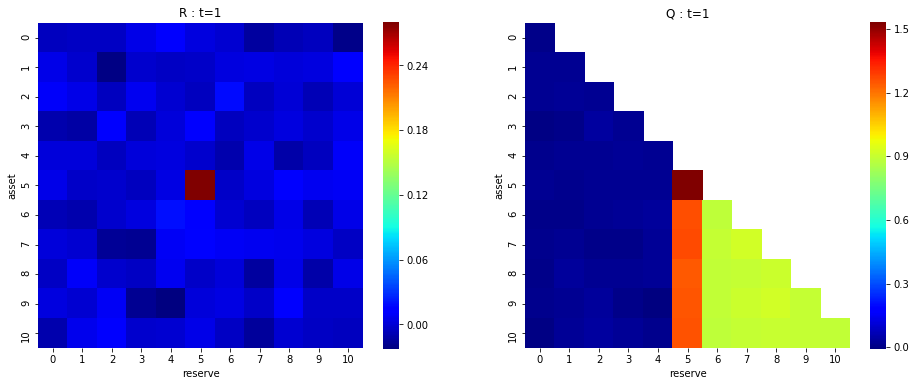

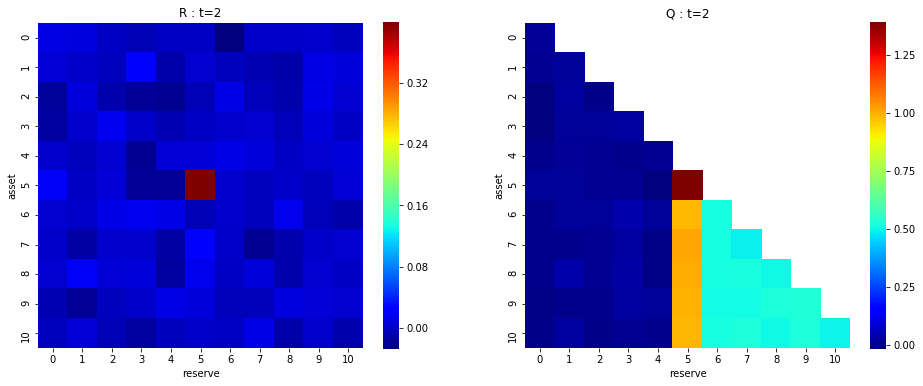

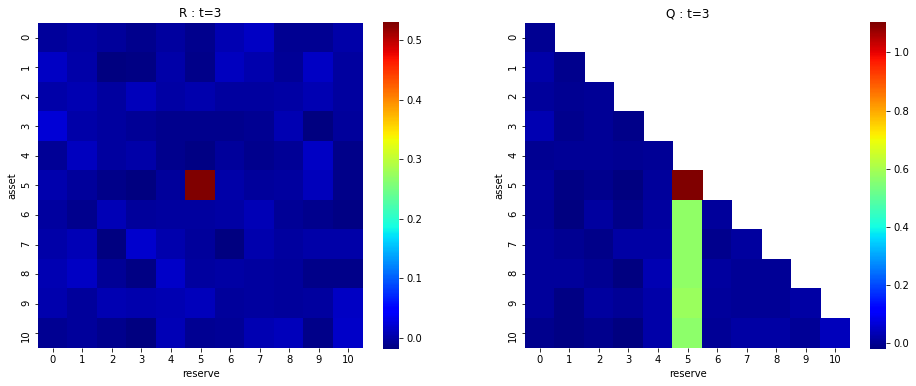

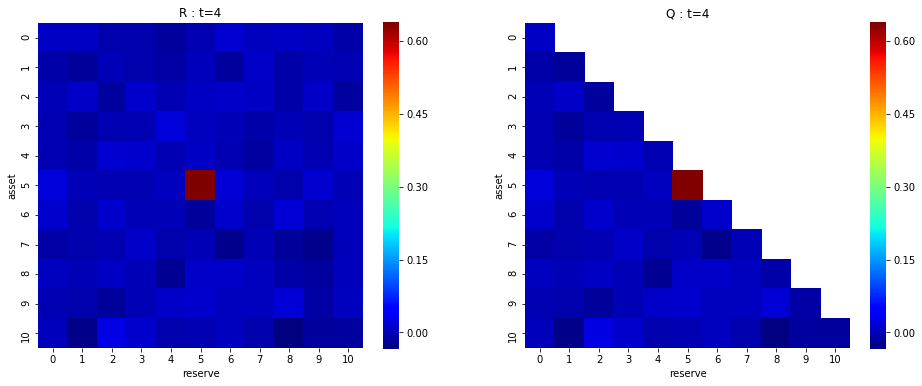

In [12]:
show_VQP(env, Rs[-1], False)

---
## 3. Bayesian IRL on all trajectries not bankrupt

In [13]:
# create R for SP annuity of term = 10
R = np.zeros(shape=(env.term, 1+env.max_asset, 1+env.max_asset))
for t in range(env.term):
    for s in range(1+env.max_asset):
        for a in range(s+1):
            R[t, s, a] = max(0, s - a)
R[-1, :, :] += np.arange(1+env.max_asset).reshape(1, -1)  # remained asset at EoY
R[-1, :, :] += env.liability_CF[-1]  # final payout
R[-1, :, :-env.liability_CF[-1]] += -30  # bunkrupt penalty
R[:, np.array(1-np.tri(len(R[-1])), dtype=bool)] = np.nan  # cut out impossible action

In [14]:
# create expert trajectories
V, Q = env.PolicyIteration(R)
policy = env.calc_greedy_policy(Q)
trajectories = env.calc_all_greedy_trajectories(policy)

In [15]:
# 先ずは非破産エキスパートのみ．
trajectories = [trajectory for trajectory in trajectories if 5<=trajectory[1]]
trajectories

[[0, 5, 5],
 [0, 6, 5],
 [0, 7, 5],
 [0, 8, 5],
 [0, 9, 5],
 [0, 10, 5],
 [1, 5, 5],
 [1, 6, 5],
 [1, 7, 5],
 [1, 8, 5],
 [1, 9, 5],
 [1, 10, 5],
 [2, 5, 5],
 [2, 6, 5],
 [2, 7, 5],
 [2, 8, 5],
 [2, 9, 5],
 [2, 10, 5],
 [3, 5, 5],
 [3, 6, 5],
 [3, 7, 5],
 [3, 8, 5],
 [3, 9, 5],
 [3, 10, 5],
 [4, 5, 5],
 [4, 6, 5],
 [4, 7, 5],
 [4, 8, 5],
 [4, 9, 5],
 [4, 10, 5]]

start :  2019-09-18 10:11:32.146549
0 th iteration...


/Users/RyoMiyazaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Users/RyoMiyazaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


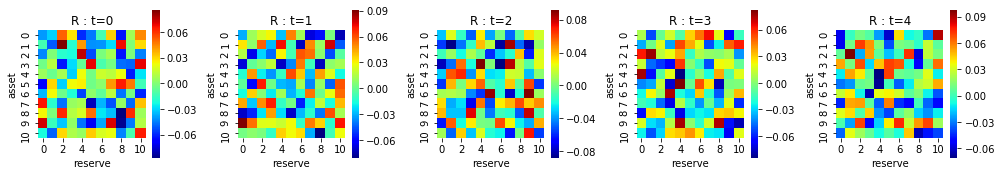

/Users/RyoMiyazaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


30000 th iteration...


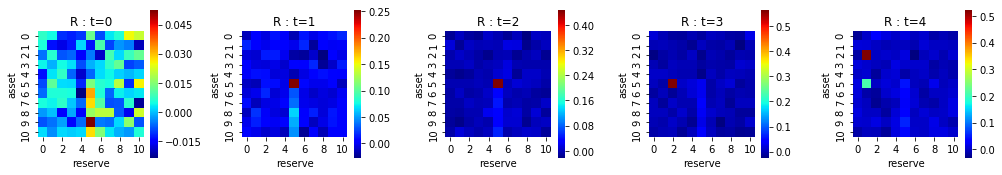

60000 th iteration...


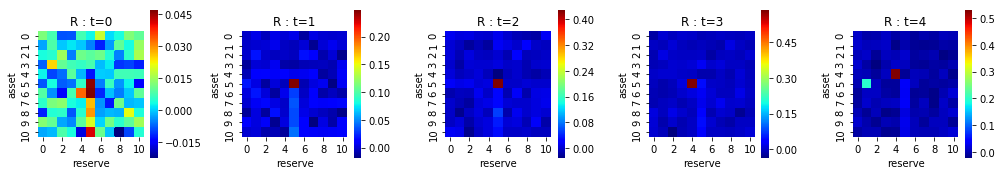

90000 th iteration...


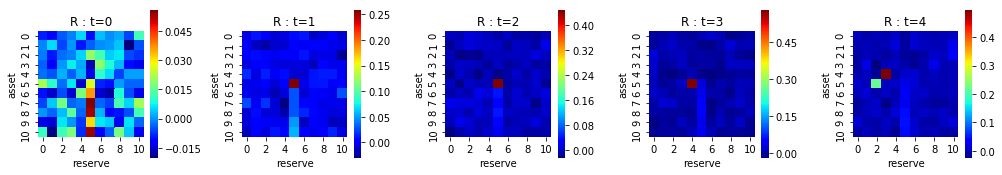

120000 th iteration...


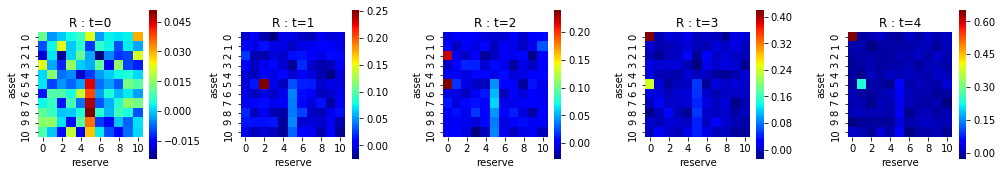

150000 th iteration...


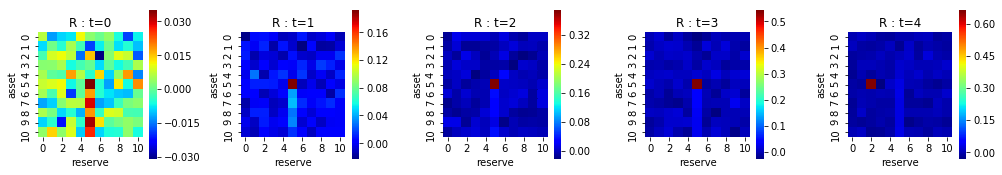

180000 th iteration...


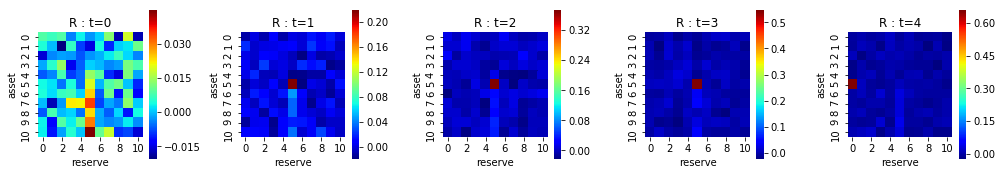

210000 th iteration...


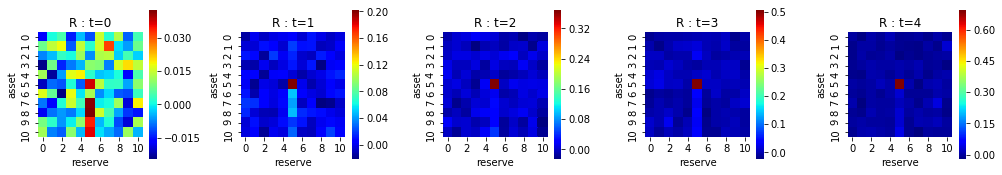

240000 th iteration...


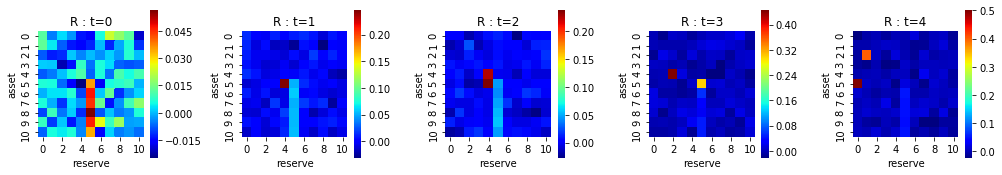

270000 th iteration...


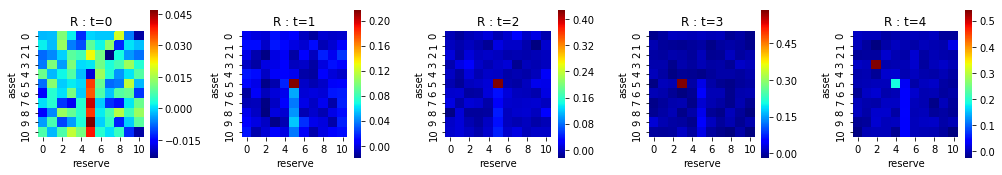

iterations = 300000, accepted = 149785, ratio = 0.49928333333333336
end :  2019-09-18 10:21:51.246370


In [16]:
print('start : ', datetime.now())
Rs = BIRL(env, trajectories, 300000, 30000, delta=1, epsilon=1.0, alpha=10000.0)
print('end : ', datetime.now())

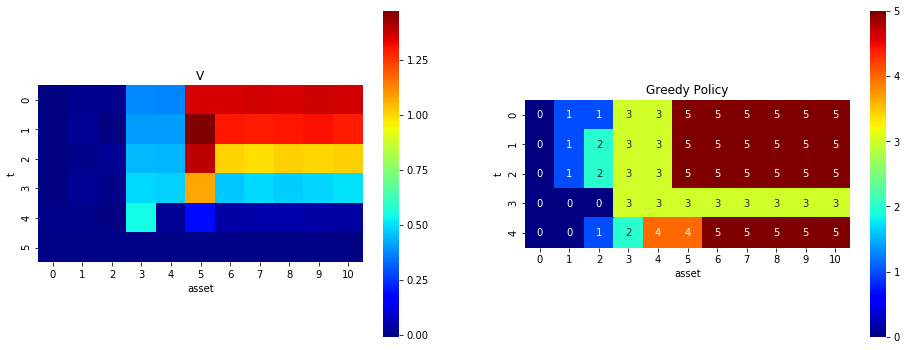

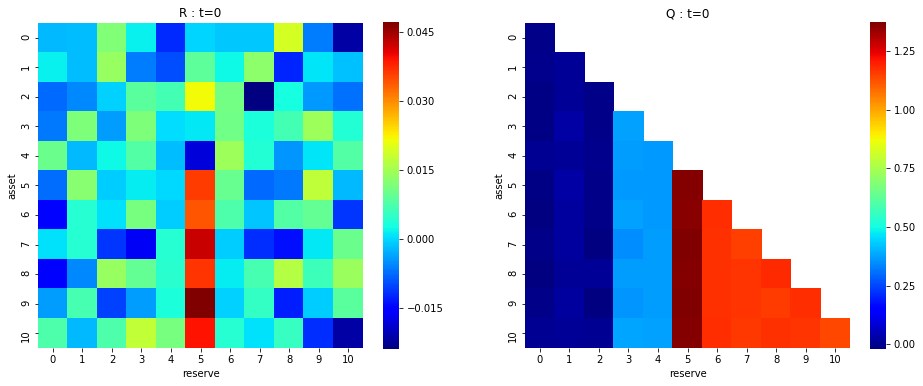

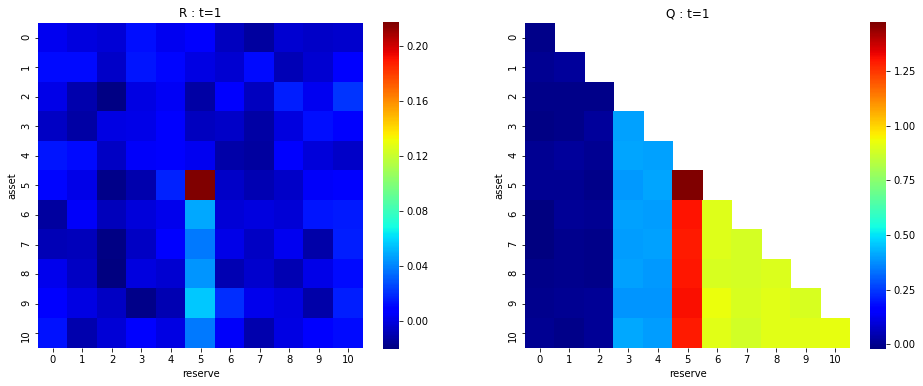

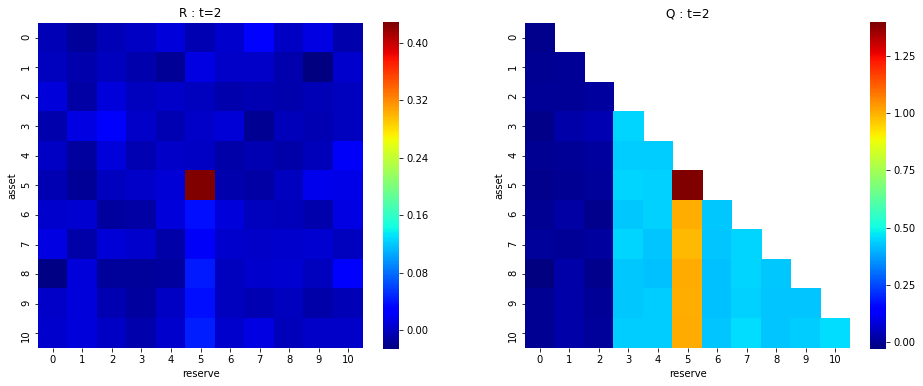

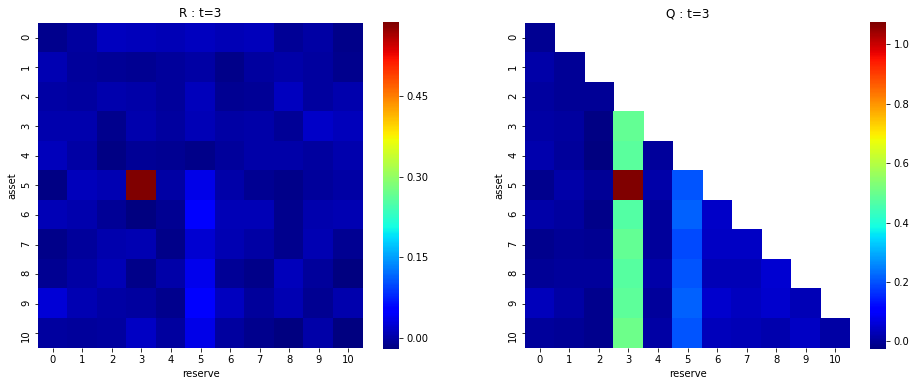

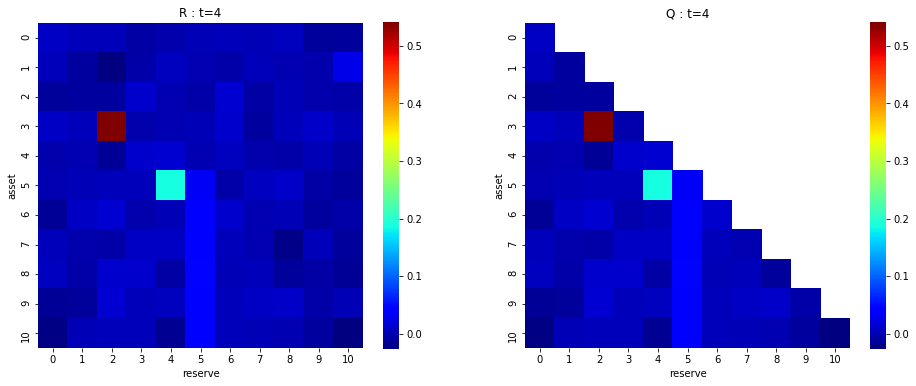

In [17]:
show_VQP(env, Rs[-1], False)

---
## 4. Bayesian IRL on all trajectries includes bankrupt

In [18]:
# create R for SP annuity of term = 10
R = np.zeros(shape=(env.term, 1+env.max_asset, 1+env.max_asset))
for t in range(env.term):
    for s in range(1+env.max_asset):
        for a in range(s+1):
            R[t, s, a] = max(0, s - a)
R[-1, :, :] += np.arange(1+env.max_asset).reshape(1, -1)  # remained asset at EoY
R[-1, :, :] += env.liability_CF[-1]  # final payout
R[-1, :, :-env.liability_CF[-1]] += -30  # bunkrupt penalty
R[:, np.array(1-np.tri(len(R[-1])), dtype=bool)] = np.nan  # cut out impossible action

In [19]:
# create expert trajectories
V, Q = env.PolicyIteration(R)
policy = env.calc_greedy_policy(Q)
trajectories = env.calc_all_greedy_trajectories(policy)

start :  2019-09-18 10:21:54.186502
0 th iteration...


/Users/RyoMiyazaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


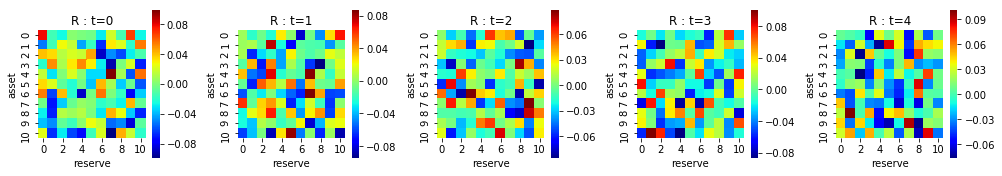

1000000 th iteration...


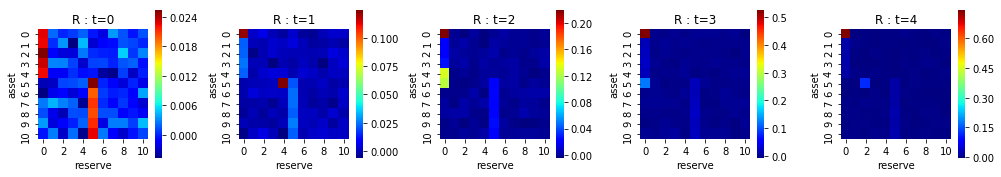

2000000 th iteration...


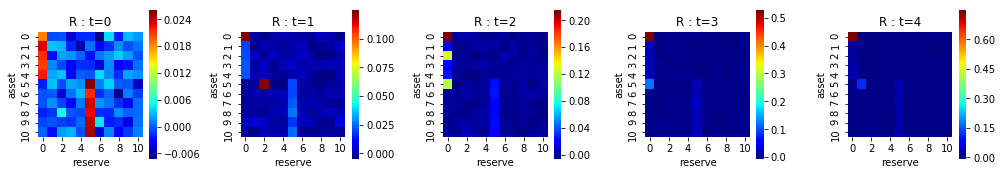

3000000 th iteration...


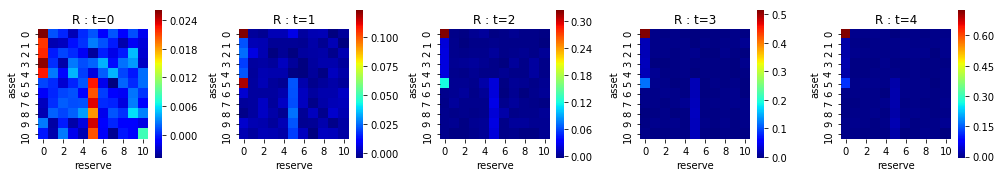

4000000 th iteration...


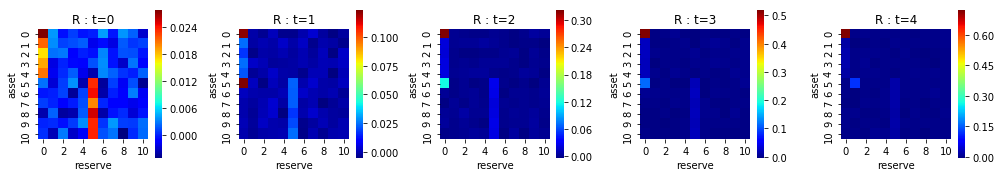

5000000 th iteration...


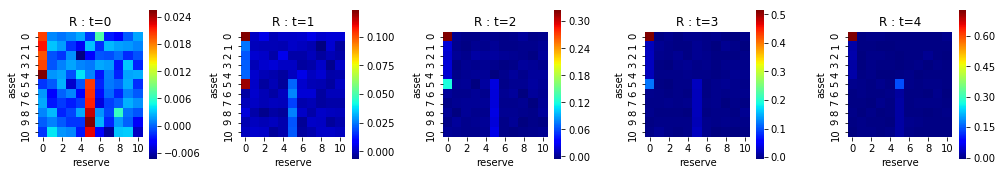

6000000 th iteration...


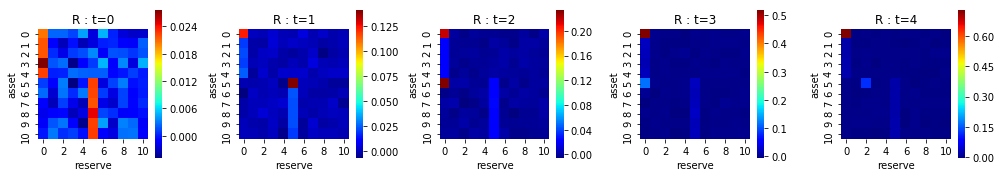

7000000 th iteration...


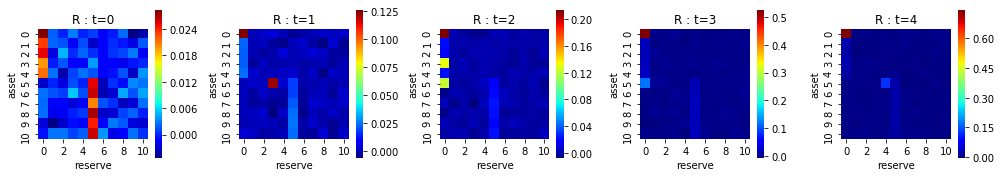

8000000 th iteration...


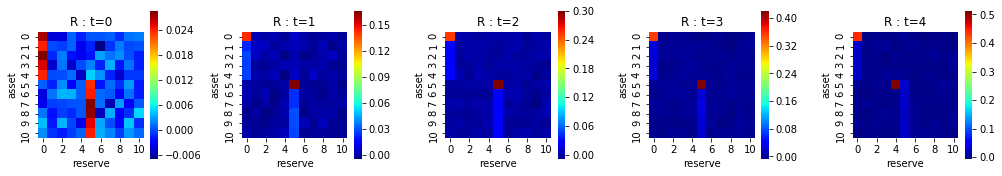

9000000 th iteration...


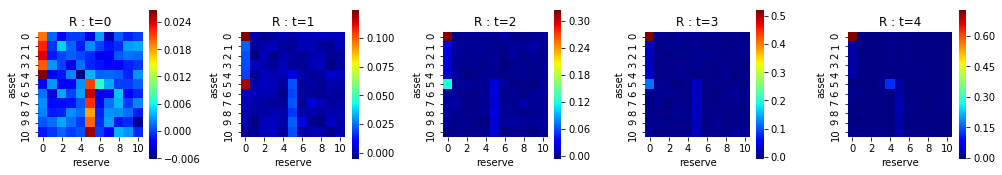

iterations = 10000000, accepted = 6523469, ratio = 0.6523469
end :  2019-09-18 15:55:34.663651


In [20]:
print('start : ', datetime.now())
Rs = BIRL(env, trajectories, 10000000, 1000000, delta=1, epsilon=1.0, alpha=10.0)
print('end : ', datetime.now())

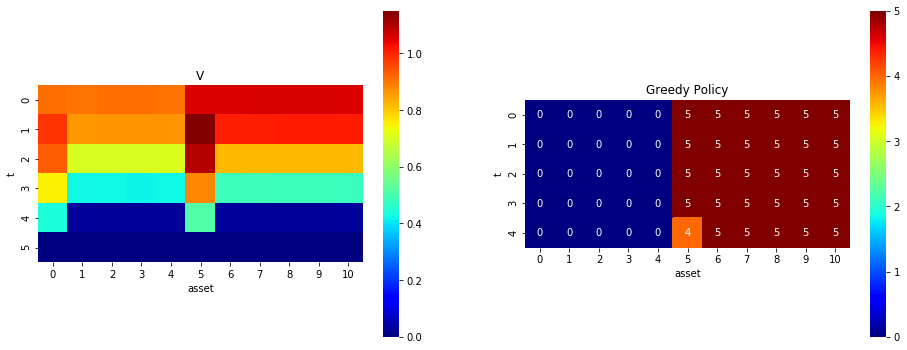

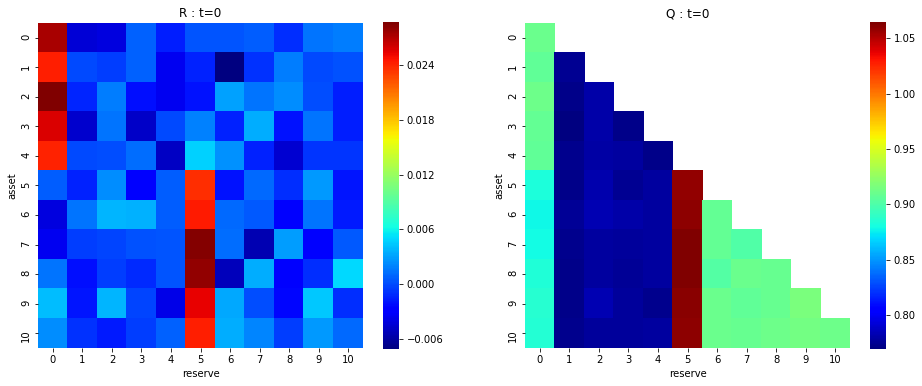

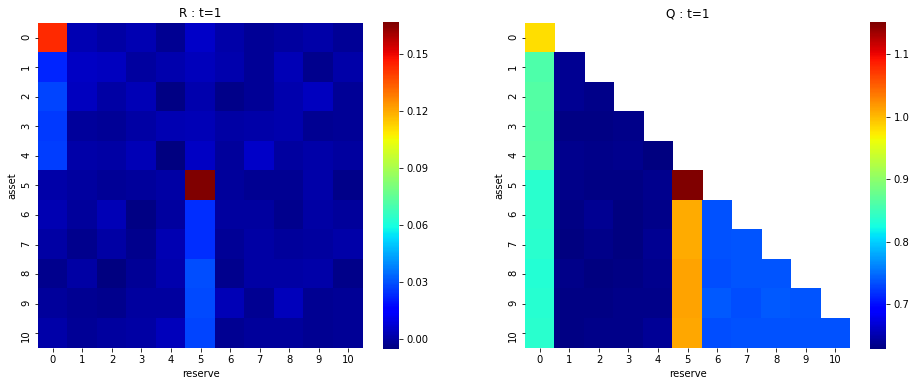

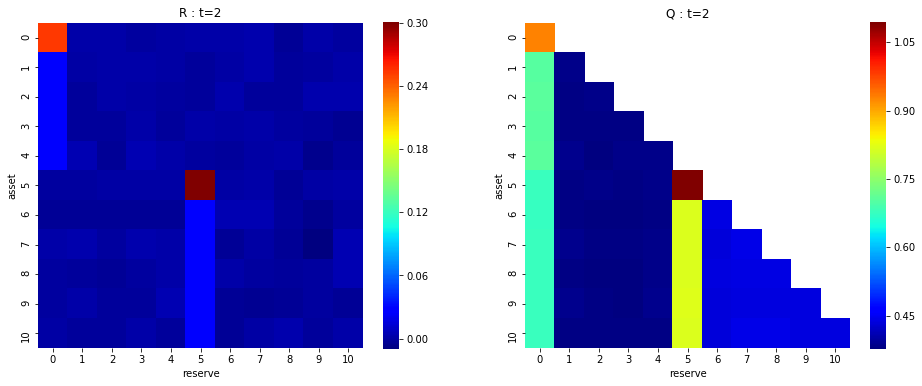

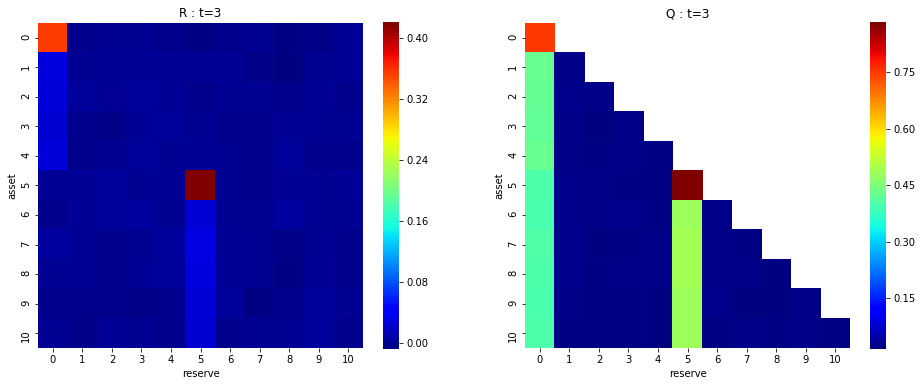

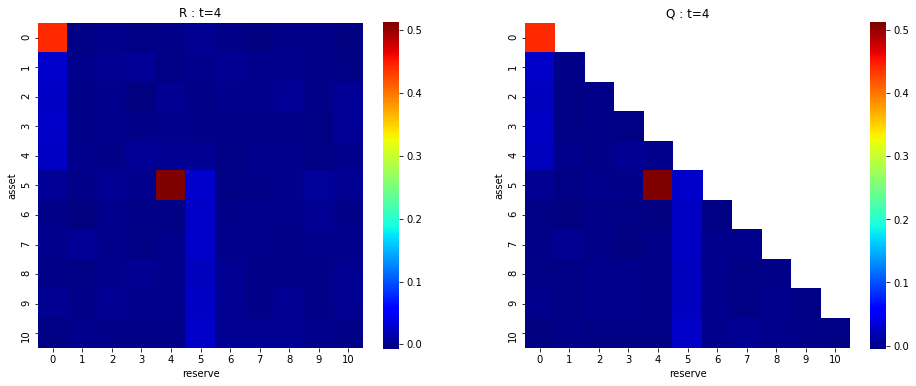

In [22]:
show_VQP(env, Rs[-2], False)

In [25]:
np.save(file='Bayesian_sample.npy', arr=Rs)